Step 1 Load two image, define the mask position

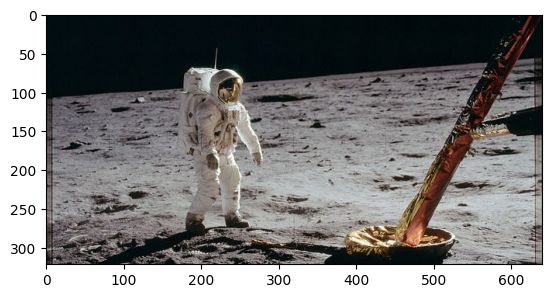

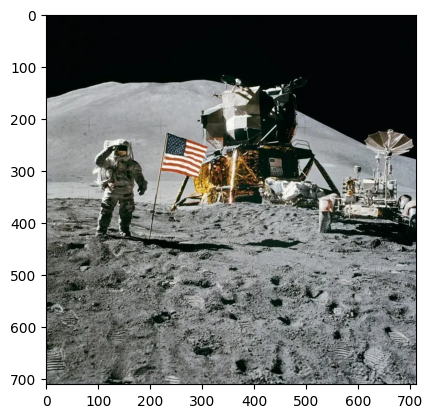

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.sparse import csr_matrix, lil_matrix, linalg

src_img_path = "../data/astronaut.jpg"
dest_img_path = "../data/Apollo_15_flag_rover_LM_Irwin-1200x1200.jpg"

src_img = cv2.imread(src_img_path); src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
plt.imshow(src_img);plt.show()
dest_img = cv2.imread(dest_img_path); dest_img = cv2.cvtColor(dest_img, cv2.COLOR_BGR2RGB)
plt.imshow(dest_img);plt.show()

[400, 610, 300, 425]


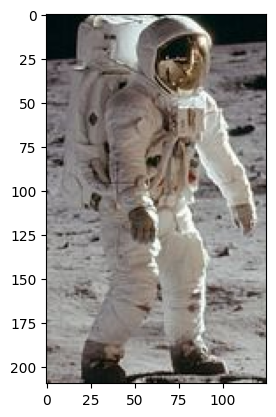

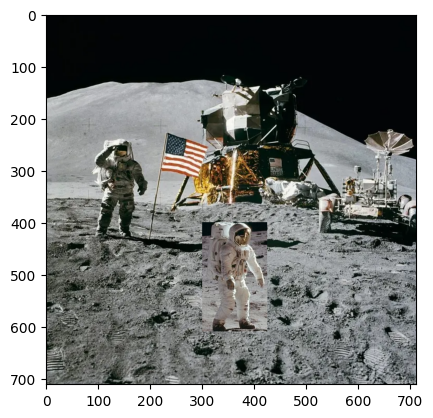

In [2]:
cut_pos = [70, 280, 160, 285]
paste_pos = [400, 400+cut_pos[1]-cut_pos[0], 300, 300+cut_pos[3]-cut_pos[2]]
print(paste_pos)
cut_img = src_img[cut_pos[0]:cut_pos[1], cut_pos[2]:cut_pos[3], :]
plt.imshow(cut_img);plt.show()
cut_paste_img = np.zeros_like(dest_img)
cut_paste_img = dest_img
cut_paste_img[paste_pos[0]:paste_pos[1], paste_pos[2]:paste_pos[3], :] = cut_img
plt.imshow(cut_paste_img);plt.show()

Step 2 

395 606 287 413


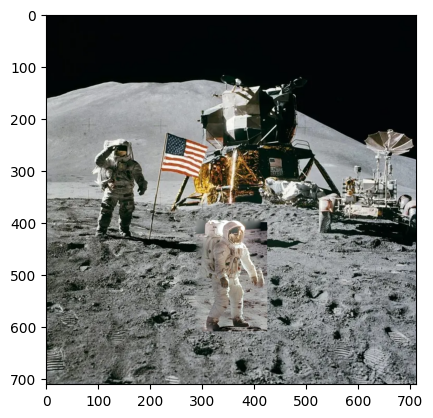

In [3]:
def seamlessClone(src,dst,mask,center,flag):
    # 1. 求源图像的散度
    laplacian = cv2.Laplacian(np.float64(src),ddepth=-1,ksize=1)
    # 2. 计算mask区域的范围
    loc = np.nonzero(mask)
    xbegin, xend, ybegin, yend = np.min(loc[0]) - 1, np.max(loc[0]) + 1, np.min(loc[1]) - 1, np.max(loc[1]) + 1
    # 3. 根据mask区域范围截取出对应的mask、src、lap
    cutMask = mask[xbegin:xend, ybegin:yend]
    cutSrc = src[xbegin:xend, ybegin:yend]
    cutLap = laplacian[xbegin:xend, ybegin:yend]
    # 4. 为了方便后面计算复制的位置，将mask、laplacian、src变成和dst一样大
    finalMask = np.zeros((dst.shape[0], dst.shape[1]))  # 只复制长和宽，单通道
    finalSrc = np.zeros_like(dst)
    finalLap = np.zeros_like(dst, dtype=np.float64)
    # 5. 根据中心点，得到融合的x、y范围
    xmid = (np.max(loc[0]) - np.min(loc[0])) // 2 + 1
    xbegin = center[0] - xmid
    xend = center[0] + cutMask.shape[0] - xmid
    ymid = (np.max(loc[1]) - np.min(loc[1])) // 2 + 1
    ybegin = center[1] - ymid
    yend = center[1] + cutMask.shape[1] - ymid

    # 复制到对应位置
    finalMask[xbegin:xend, ybegin:yend] = cutMask
    print(xbegin, xend, ybegin, yend)
    finalSrc[xbegin:xend, ybegin:yend] = cutSrc
    finalLap[xbegin:xend, ybegin:yend] = cutLap

    # 6. 求融合散度
    if flag == 1:
        kernel = [np.array([[0, -1, 1]]),np.array([[1, -1, 0]]), np.array([[0], [-1], [1]]), np.array([[1], [-1], [0]])] # 四个方向梯度的过滤器，分别为x正方向、x反方向、y正方向、y反方向，散度就是在同一个方向进行两次梯度计算
        # 求src图、dst梯度
        grads = []
        for i in range(4):
            srcGrad = cv2.filter2D(np.float64(finalSrc), -1, kernel[i])
            dstGrad = cv2.filter2D(np.float64(dst), -1, kernel[i])
            grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad)) # 哪个梯度大就取哪个
        finalLap = np.sum(grads, axis=0) # 四个梯度求和，即两个散度求和，得到最终的散度 
    # 7. 逐通道求解
    result = [getX(a, finalMask, b) for a, b in zip(cv2.split(dst), cv2.split(finalLap))]
    
    # 合并三个通道
    final = cv2.merge(result)
    return final


def getX(dst, mask, lap):
    # 1 计算求解的像素个数
    loc = np.nonzero(mask)
    num = loc[0].shape[0] 
    # 2. 有多少个像素个数则需要多少个方程，需要构造num*num大小的稀疏矩阵和num大小的b向量
    # 3. A用lilmatrix，这种矩阵方便逐个添加
    A = lil_matrix((num, num), dtype=np.float64)
    b = np.ndarray((num, ), dtype=np.float64) # 一维数组,长度只有1, 而且最外层的长度为num
    # 4. 要将每个像素映射到0~num-1的索引之中，因为A系数矩阵也是根据索引求构造的
    hhash = {(x, y): i for i, (x, y) in enumerate(zip(loc[0], loc[1]))}
    # 用于找上下左右四个像素位置
    dx = [1,0,-1,0]
    dy = [0,1,0,-1]
    # 5. 构造A系数矩阵和b向量 
    for i, (x, y) in enumerate(zip(loc[0],loc[1])):
        A[i, i] = -4
        b[i] = lap[x, y]
        p = [(x + dx[j], y + dy[j]) for j in range(4)] # p为上下左右的像素位置
        for j in range(4):
            if p[j] in hhash: # 像素位置在mask内
                A[i, hhash[p[j]]] = 1
            else:
                b[i] -= dst[p[j]]
                
    # 由于A是稀疏矩阵，可以将lilmatrix转成cscmatrix，方便矩阵运算
    A = A.tocsc()
    # 6. 求解X
    X = linalg.splu(A).solve(b)

    # 7. 将X复制到对应位置
    result = np.copy(dst)
    for i, (x, y) in enumerate(zip(loc[0],loc[1])):
        if X[i] < 0:
            X[i] = 0
        if X[i] > 255:
            X[i] = 255
        result[x, y] = X[i]

    return result

mask = np.zeros((src_img.shape[0], src_img.shape[1]))
mask[cut_pos[0]:cut_pos[1], cut_pos[2]:cut_pos[3]] = 1
gb = seamlessClone(src_img, dest_img, mask, [500, 350], 0)
plt.imshow(gb)
plt.show()